In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

Generate pseudo-data

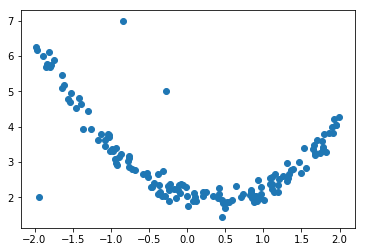

In [2]:
n = 150
np.random.seed(110104)
x = 4.0 * (np.random.rand(n) - 0.5)
xfeat = np.column_stack((x**i for i in range(1, 9))) # polynomials up to degree 8
y = 2.0 - 0.2*x + 0.2*(2*x - 0.5)**2 + 0.2 * np.random.randn(n)
y[2] = 4.0 # Artificial outliers
y[3] = 7.0 # Artificial outliers
y[10] = 5.0 # Artificial outliers
y = y.reshape((n, 1))

plt.scatter(x, y)

Let's split data in test and train (we'll use only train for Bayesian evidence and test for cross-validation)

In [3]:
n_train = 75
xfeat_train, y_train = xfeat[:n_train, :], y[:n_train, :]
xfeat_test, y_test = xfeat[n_train:, :], y[n_train:, :]

This is a function to generate training batches

In [4]:
def get_batches(xfeat, y, batch_size):
    n_batches = xfeat.shape[0] // batch_size
    for i in range(n_batches):
        yield xfeat[i*batch_size:(i + 1)*batch_size,:], y[i*batch_size:(i + 1)*batch_size,:]

Create a very simple architecture with one hidden and a l2 regulariser

In [5]:
def nn_input(dim_features, dim_output):
    features = tf.placeholder(tf.float32, (None, dim_features))
    target = tf.placeholder(tf.float32, (None, dim_output))
    lr = tf.placeholder(tf.float32)
    penalty = tf.placeholder(tf.float32)
    precision = tf.placeholder(tf.float32)
    return features, target, lr, penalty, precision
    
def hidden_layer(features, dim_features, dim_hidden):
    # The weights are created as a vector so that taking hessian is easier
    W = tf.Variable(tf.truncated_normal((dim_features*dim_hidden, ), stddev=1/np.sqrt(dim_features*dim_hidden)))
    Wmat = tf.reshape(W, (dim_features, dim_hidden))
    b = tf.Variable(tf.zeros(dim_hidden))
    hidden = tf.nn.relu(tf.matmul(features, Wmat) + b)
    return hidden, W, b

def output_layer(hidden, dim_hidden, dim_output):
    # The weights are created as a vector so that taking hessian is easier
    W2 = tf.Variable(tf.truncated_normal((dim_hidden*dim_output, ), stddev=1/np.sqrt(dim_hidden*dim_output)))
    W2mat = tf.reshape(W2, (dim_hidden, dim_output))
    b2 = tf.Variable(tf.zeros(1))
    output = tf.matmul(hidden, W2mat) + b2
    return output, W2, b2

def nn_loss(output, target, penalty, precision, W, W2):
    errors = output - target
    weights = tf.concat([W, W2], axis = 0)
    loss = precision * tf.reduce_sum(tf.square(errors)) + penalty * tf.reduce_sum(tf.square(weights))
    return loss, errors, weights

def nn_optimization(loss, lr):
    optim = tf.train.AdamOptimizer(lr).minimize(loss)
    return optim
    
class neural_network():
    def __init__(self, dim_features, dim_output, dim_hidden):
        self.features, self.target, self.lr, self.penalty, self.precision = nn_input(dim_features, dim_output)
        self.hidden, self.W, self.b = hidden_layer(self.features, dim_features, dim_hidden)
        self.output, self.W2, self.b2 = output_layer(self.hidden, dim_hidden, dim_output)
        self.loss, self.errors, self.weights = nn_loss(
            self.output, self.target, self.penalty, self.precision, self.W, self.W2)
        self.optim = nn_optimization(self.loss, self.lr)
        self.hessian = tf.hessians(self.loss, [self.W, self.W2])[0] # Jesus! Hessians!

Now create the neural network

In [6]:
dim_features = xfeat_train.shape[1]
dim_output = y_train.shape[1]
dim_hidden = 50

tf.reset_default_graph()
nn = neural_network(dim_features, dim_output, dim_hidden) # Takes some time to create just because there is a hessian!
nn.__dict__

{'W': <tf.Variable 'Variable:0' shape=(400,) dtype=float32_ref>,
 'W2': <tf.Variable 'Variable_2:0' shape=(50,) dtype=float32_ref>,
 'b': <tf.Variable 'Variable_1:0' shape=(50,) dtype=float32_ref>,
 'b2': <tf.Variable 'Variable_3:0' shape=(1,) dtype=float32_ref>,
 'errors': <tf.Tensor 'sub:0' shape=(?, 1) dtype=float32>,
 'features': <tf.Tensor 'Placeholder:0' shape=(?, 8) dtype=float32>,
 'hessian': <tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, 400) dtype=float32>,
 'hidden': <tf.Tensor 'Relu:0' shape=(?, 50) dtype=float32>,
 'loss': <tf.Tensor 'add_2:0' shape=<unknown> dtype=float32>,
 'lr': <tf.Tensor 'Placeholder_2:0' shape=<unknown> dtype=float32>,
 'optim': <tf.Operation 'Adam' type=NoOp>,
 'output': <tf.Tensor 'add_1:0' shape=(?, 1) dtype=float32>,
 'penalty': <tf.Tensor 'Placeholder_3:0' shape=<unknown> dtype=float32>,
 'precision': <tf.Tensor 'Placeholder_4:0' shape=<unknown> dtype=float32>,
 'target': <tf.Tensor 'Placeholder_1:0' shape=(?, 1) dtype=float32>,
 

We now train and evaluate the network

epoch  1 training loss 17790.0508
epoch 50 training loss 1107.5819
epoch 100 training loss 917.8268
epoch 150 training loss 899.8101
epoch 200 training loss 910.8828
epoch 250 training loss 920.6224
epoch 300 training loss 912.0665
epoch 350 training loss 900.4312
epoch 400 training loss 902.7212
epoch 450 training loss 899.2335
epoch 500 training loss 910.1176


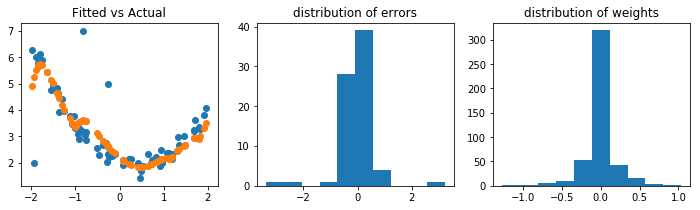

In [7]:
epochs = 500
print_every_epochs = 50
batch_size = 10
lr = 0.01
penalty = 0.00000001
precision = 25.0 # because we use noise with sigma = 0.2

hyperparams= {nn.penalty: penalty, nn.precision: precision, nn.lr: lr}
full_training_feed = {nn.features: xfeat_train, nn.target: y_train, **hyperparams}

with tf.Session() as sess:
    # Training
    sess.run(tf.global_variables_initializer())
 
    for epoch in range(epochs):
        for batch_x, batch_y in get_batches(xfeat_train, y_train, batch_size):
            batch_feed = {nn.features: batch_x, nn.target: batch_y, **hyperparams}
            sess.run(nn.optim, batch_feed)
        if epoch == 0 or (epoch  + 1) % print_every_epochs == 0:
            loss = sess.run(nn.loss, full_training_feed)
            print("epoch %2d training loss %4.4f" % (epoch + 1, loss))

    # Visualize fit, errors, and weights
    errors, weights, output = sess.run([nn.errors, nn.weights, nn.output], full_training_feed)
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 3))
    ax0.scatter(xfeat_train[:,0], y_train)
    ax0.scatter(xfeat_train[:,0], output)
    ax0.set_title('Fitted vs Actual')
    ax1.hist(errors)
    ax1.set_title('distribution of errors')
    ax2.hist(weights)
    ax2.set_title("distribution of weights")

Let's repeat this but with Bayesian evidence!

In [8]:
def log_evidence(hessian, loss, penalty, precision, dim_hidden, n_obs, n_weights):
    s, logdet = np.linalg.slogdet(hessian)
    N, k = n_obs, n_weights
    posterior_energy = -0.5 * loss + 0.5 * k * np.log(2*np.pi) - 0.5 * logdet
    weights_energy = 0.5 * k * np.log(2 * np.pi / penalty) 
    model_energy = 0.5 * N * np.log(2 * np.pi / precision)
    symmetry_factor = dim_hidden * np.log(2) + np.sum(np.log(np.arange(1, dim_hidden + 1)))
    return symmetry_factor + posterior_energy - weights_energy - model_energy

In [9]:
def test_nn(
        xfeat_train, y_train,
        xfeat_test, y_test,
        dim_hidden, 
        epochs,
        batch_size,
        lr,
        penalty,
        precision): 
    # Create network
    dim_features = xfeat.shape[1]
    dim_output = y.shape[1]
    tf.reset_default_graph()
    nn = neural_network(dim_features, dim_output, dim_hidden) # Takes some time to create just because there is a hessian!
    # Feed dictionaries
    hyperparams= {nn.penalty: penalty, nn.precision: precision, nn.lr: lr}
    with tf.Session() as sess:
        # Train
        sess.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            for batch_x, batch_y in get_batches(xfeat_train, y_train, batch_size):
                batch_feed = {nn.features: batch_x, nn.target: batch_y, nn.lr: lr, **hyperparams}
                sess.run(nn.optim, batch_feed)
        # Find Bayesian (Log)evidence
        full_train_feed = {nn.features: xfeat_train, nn.target: y_train, **hyperparams}
        full_test_feed = {nn.features: xfeat_test, nn.target: y_test, **hyperparams}
        hessian, loss_train, output, weights = sess.run([nn.hessian, nn.loss, nn.output, nn.weights], full_train_feed)
        evidence = log_evidence(hessian, loss_train, penalty, precision, dim_hidden, len(output), len(weights)) 
        loss_test = sess.run(nn.loss, full_test_feed)
        return evidence, loss_train, loss_test

Test and compare evidence for multiple precisions and noises

In [10]:
# Optimization parameters
epochs = 500
batch_size = 10
lr = 0.01

# Network parameters
dim_hidden_list = [2, 5, 10, 25, 50, 100]
penalty_list = [0.00000001, .00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
precision = 25.0

evidence_trace = []
generror_trace = []
for dim_hidden in dim_hidden_list:   
    for penalty in penalty_list:     
        bayes_train, loss_train, loss_test = test_nn(
            xfeat_train, y_train, xfeat_test, y_test, dim_hidden, epochs, batch_size, lr, penalty, precision)
        evidence_trace.append(bayes_train)
        generror_trace.append(loss_test)
        print_str = 'dim_hid: %4d  penalty: %14.8f evidence: %9.2f' + \
            ' loss_train: %9.2f loss_test: %9.2f '
        print(print_str %(dim_hidden, penalty, bayes_train, loss_train, loss_test))

dim_hid:    2  penalty:     0.00000001 evidence:   -591.45 loss_train:    930.00 loss_test:    157.71 
dim_hid:    2  penalty:     0.00001000 evidence:   -633.35 loss_train:   1207.23 loss_test:    800.02 
dim_hid:    2  penalty:     0.00010000 evidence:   -523.06 loss_train:    931.65 loss_test:    166.69 
dim_hid:    2  penalty:     0.00100000 evidence:   -597.01 loss_train:   1221.68 loss_test:    790.66 
dim_hid:    2  penalty:     0.01000000 evidence:   -470.03 loss_train:    921.28 loss_test:    161.26 
dim_hid:    2  penalty:     0.10000000 evidence:   -449.66 loss_train:    928.52 loss_test:    158.19 
dim_hid:    2  penalty:     1.00000000 evidence:   -447.59 loss_train:    940.14 loss_test:    153.88 
dim_hid:    2  penalty:    10.00000000 evidence:   -482.78 loss_train:   1020.19 loss_test:    195.84 
dim_hid:    2  penalty:   100.00000000 evidence:   -570.44 loss_train:   1215.16 loss_test:    317.88 
dim_hid:    5  penalty:     0.00000001 evidence:   -666.82 loss_train:   

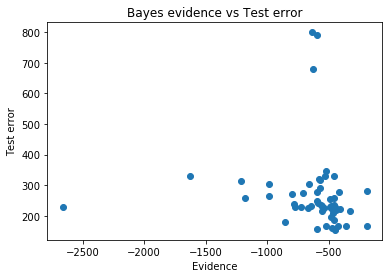

In [13]:
plt.scatter(evidence_trace, generror_trace)
plt.title('Bayes evidence vs Test error')
plt.xlabel('Evidence')
plt.ylabel('Test error')

(-1600, -200)

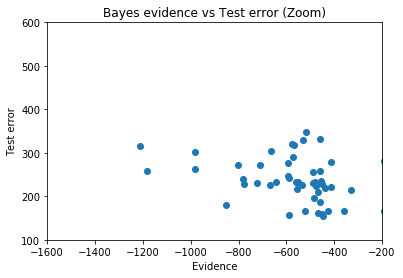

In [14]:
plt.scatter(evidence_trace, generror_trace)
plt.title('Bayes evidence vs Test error (Zoom)')
plt.xlabel('Evidence')
plt.ylabel('Test error')
plt.ylim(100, 600)
plt.xlim(-1600, -200)